In [1]:
%matplotlib inline
import numpy as np
import GPy
from pylab import *
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

In [2]:
def forrester(X):
    return((6*X -2)**2)*np.sin(12*X-4)
np.random.seed(0)

## A GP Regression Example

In [3]:
N =8
X = np.random.rand(N, 1)
Y = forrester(X) + np.random.randn(N,1)*0.01

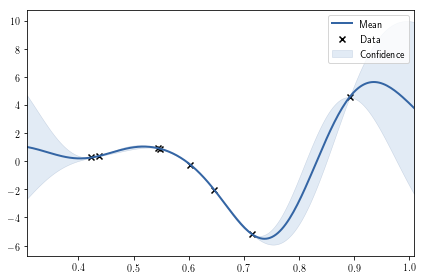

In [4]:
m = GPy.models.GPRegression(X, Y, noise_var=0.0001)
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
fig.tight_layout()
fig.savefig('../diagrams/gp_first_example.pdf')

## GP runtime scaling behavior

In [5]:
import time
Ns = [10, 100, 500, 1000, 1500, 2000]
times = []
for N in Ns:
    X = np.random.rand(N, 1)
    Y = forrester(X) + np.random.randn(N,1)*0.01
    m = GPy.models.GPRegression(X, Y)
    time_start = time.time()
    m._trigger_params_changed()
    time_end = time.time()
    times.append(time_end - time_start)

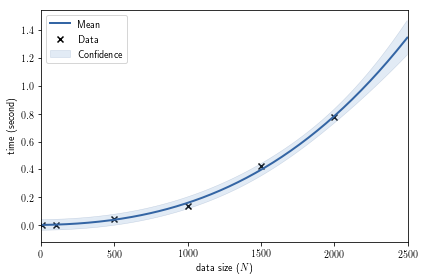

In [6]:
m2 = GPy.models.GPRegression(np.array(Ns)[:,None], np.array(times)[:,None], kernel=GPy.kern.Poly(1, order=3))
m2.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m2.plot(ax=ax)
ax.set_xlim(0,2500)
ax.set_xlabel('data size ($N$)')
ax.set_ylabel('time (second)')
fig.tight_layout()
fig.savefig('../diagrams/gp_scaling.pdf')

## A quick GP log-likelihood profiling

In [7]:
from scipy.linalg.lapack import dtrtrs
def compute_log_likelihood(kern, X, Y, sigma2):
    N = X.shape[0]
    K = kern.K(X)
    Ky = K + np.eye(N)*sigma2
    L = np.linalg.cholesky(Ky)
    LinvY = dtrtrs(L, Y, lower=1)[0]
    logL = N*np.log(2*np.pi)/-2.
    logL += np.square(LinvY).sum()/-2.
    logL += -np.log(np.diag(L)).sum()
    return logL

__Run the following Python code. (line_profiler is required.)__
```python
X = np.random.rand(1000,10)
Y = np.random.rand(1000,1)
k = GPy.kern.RBF(10)
sigma2 = 0.01
%load_ext line_profiler
%lprun -f compute_log_likelihood compute_log_likelihood(k, X, Y, sigma2)
```


__The outcome is as follows:__

Timer unit: 1e-06 s

Total time: 0.094684 s
File: <ipython-input-12-507b55833290>
Function: compute_log_likelihood at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     2                                           def compute_log_likelihood(kern, X, Y, sigma2):
     3         1          6.0      6.0      0.0      N = X.shape[0]
     4         1      55595.0  55595.0     58.7      K = kern.K(X)
     5         1       4369.0   4369.0      4.6      Ky = K + np.eye(N)*sigma2
     6         1      30012.0  30012.0     31.7      L = np.linalg.cholesky(Ky)
     7         1       4361.0   4361.0      4.6      LinvY = dtrtrs(L, Y, lower=1)[0]
     8         1         49.0     49.0      0.1      logL = N*np.log(2*np.pi)/-2.
     9         1         82.0     82.0      0.1      logL += np.square(LinvY).sum()/-2.
    10         1        208.0    208.0      0.2      logL += -np.log(np.diag(L)).sum()
    11         1          2.0      2.0      0.0      return logL

## Normal GP and Sparse GP with a lot of data

In [8]:
N =100
X = np.random.rand(N, 1)
Y = forrester(X) + np.random.randn(N,1)*1.

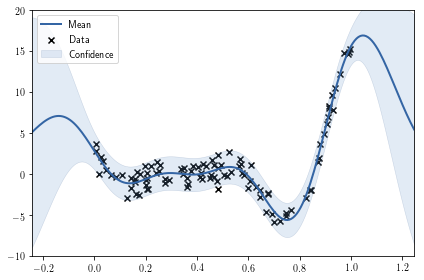

In [11]:
m = GPy.models.GPRegression(X, Y, noise_var=0.0001)
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
ax.set_ylim(-10,20)
fig.tight_layout()
fig.savefig('../diagrams/gp_example_lots_data.pdf')

In [15]:
K = m.kern.K(X)
eigv = np.linalg.eigvalsh(K)

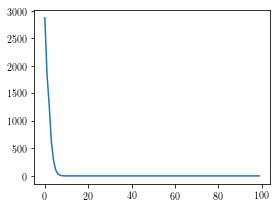

In [25]:
fig = figure(figsize=(4,3))
ax = fig.gca()
ax.plot(eigv[::-1])
#ax.set_yscale("log", nonposy='clip')
fig.tight_layout()
fig.savefig('../diagrams/lots_data_eigen_values.pdf')

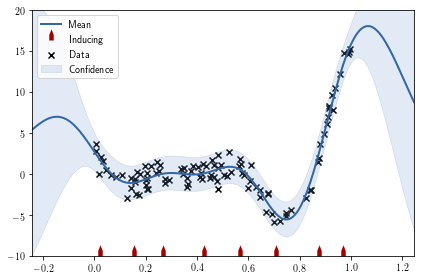

In [10]:
m = GPy.models.SparseGPRegression(X, Y, num_inducing=8)
m.likelihood.variance = 1e-4
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
ax.set_ylim(-10,20)
fig.tight_layout()
fig.savefig('../diagrams/sparsegp_example_lots_data.pdf')

## Too many inducing points

In [25]:
np.random.seed(0)
N =8
X = np.random.rand(N, 1)
Y = forrester(X) + np.random.randn(N,1)*0.01

('defaulting to ', <GPy.inference.latent_function_inference.var_dtc.VarDTC object at 0x116265940>, 'for latent function inference')


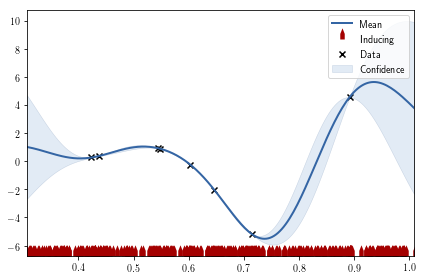

In [26]:
# Force sparse GP to take a lot of inducing points.
m = GPy.core.SparseGP(X, Y, np.random.rand(500,1), GPy.kern.RBF(1), GPy.likelihoods.Gaussian(variance=0.01))
m.likelihood.variance = 1e-4
m.optimize()
fig = figure(figsize=(6,4))
ax = fig.gca()
m.plot(ax=ax)
fig.tight_layout()
fig.savefig('../diagrams/sparsegp_example_lots_inducing_points.pdf')